# Ex 4: Parallel Transmission Pulse Design

We will wrap up the exercises for this session with a type of pulse design that visibly leverages some of the nicer abstractions within SigPy: parallel transmit pulse design.

Specifically, in this exercise we will focus on a spatial-domain spiral parallel transmit pulse design.

We start by writing our import statements one last time:

In [462]:
%matplotlib inline

# typical sigpy and numpy imports
import sigpy
import numpy as np
import sigpy.mri as mr
import sigpy.mri.rf as rf # importing our rf tools separately
import sigpy.plot as pl

# to assist with importing data, we will also import scipy
import scipy.io as sio
import scipy.ndimage as nd

import matplotlib.pyplot as mplib

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from PIL import Image

In [463]:
image = Image.open('uva.png')

# downsize the image with an ANTIALIAS filter (gives the highest quality)
d = image.resize((32,32), Image.LANCZOS)

d = np.flipud(d).mean(axis=-1)

d = (d - np.amin(d))/(np.amax(d) - np.amin(d))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24304\4274421214.py:4: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  d = image.resize((32,32), Image.LANCZOS)


For this problem, use a small problem geometry: a 2D 32x32 design grid with 8 channels, to keep computation simple for Binder! However, if you are running these exercises locally and have more RAM available, larger designs are no problem. 

In [464]:
# problem size is provided: 
dim_x = d.shape[0] # Size of image
dim_y = d.shape[1]
Nc = 8 # Number of pTx channels
sens_shape = [Nc, dim_x, dim_y] # Sensitivity map shape: one per channel
img_shape = [dim_x, dim_y] # Size of 2D image

To begin, we will want some two-dimensional spatial magnetization pattern to design for. We provide one pattern in a matlab file for use in the data folder of this notebook, which we will load here. This is just to get you started - feel free to load other patterns or create your own! 

In [465]:
# loading the data
#mat_struct = sio.loadmat('smallv.mat')
#d = mat_struct['d'].astype(np.single)
#pl.ImagePlot(d, title='Target Excitation Pattern', colormap="gray")

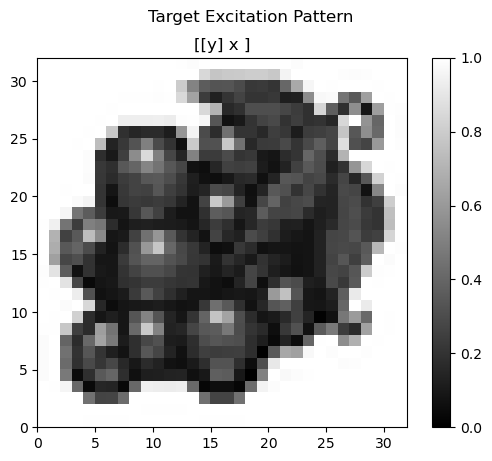

In [466]:
pl.ImagePlot(d, title='Target Excitation Pattern', colormap="gray")

This is an interesting pattern, but the edges are extremely sharp. To avoid introducing Gibbs ringing into our design from these sharp edges, we will perform a very slight blur of the pattern using scipy. Our scipy filter requires real-valued numbers but we will want to use complex values in the design later, so we will cast to complex after the blurring is performed.

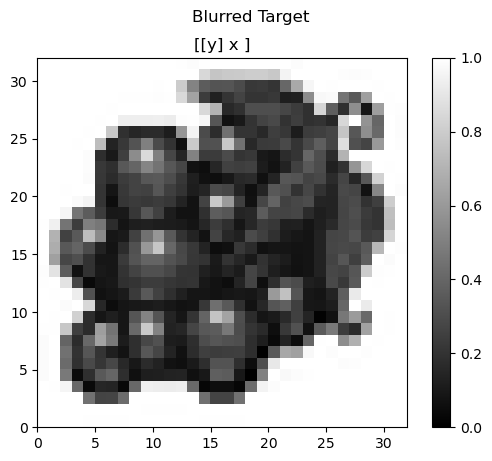

In [467]:
# smoothing the design pattern
d = nd.gaussian_filter(d, 0.0)
d = d.astype(complex)
pl.ImagePlot(d, title='Blurred Target', colormap="gray")

## Problem 4a: Simulate our transmit coil sensitivities.

Here, we will break out the more general sigpy.mri submodule functions for the first time. Use [sigpy.mri.birdcage_maps()](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.birdcage_maps.html#sigpy.mri.birdcage_maps) to simulate our B1+ transmit sensitivities. Note that these simulated profiles would be equally valid to use as receive sensitivities for a reconstruction problem, such as a SENSE recon.

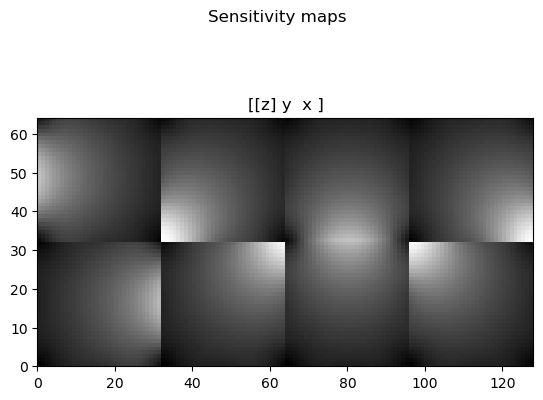

In [468]:
sens = mr.birdcage_maps(sens_shape)
pl.ImagePlot(sens, z=0, mode= "m" ,title='Sensitivity maps')

**If you haven't already, take a moment to play around with some of the hotkey features of sigpy.plot using the (complex-valued) sensitivities plot produced above. After clicking on the plot, try the following hotkeys:**
* Up and down arrows - scroll through currently selected dimension
* Left and right arrows - change which dimension is selected (indicated by [brackets])
* m - magnitude plot
* p - phase plot
* r - real plot
* i - imaginary plot

You should be able to look at each of the coils' B1 sensitivities sequentially, and view their magnitude, phase, or real/imaginary components! 

## Problem 4b: Create a spiral trajectory.

Before performing our design, we will also need to design time-varying gradient waveforms to produce a trajectory for our excitation.

* Design a spiral-in trajectory using [*sigpy.mri.rf.spiral_arch()*](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.trajgrad.spiral_arch.html#sigpy.mri.rf.trajgrad.spiral_arch). Note that by default this trajectory designer produces a spiral-out trajectory - **you will need to flip the waveforms to spiral inward!** Numpy has functions that can assist with this, or you can use python built-ins (such as vector = vector[::-1])


* Given: 
    * a FOV of 0.55 m
    * a maximum slew rate of 150 mT/m/ms
    * a hardware dwell time of 6.4e-6 s
    * a maximum gradient amplitude of 30 mT/m
    * res = 0.025 m


*Hint: to under- or oversample with the spiral use fov = fov/R. Over-sampling is done with R < 1.*

In [469]:
# assign values to the variables below
fov =   0.55 # FOV in m
gts =   6.4E-6 # hardware dwell time, s
gslew =   150 # gradient slew rate in mT/m/ms
gamp =  30 # maximum gradient amplitude in mT/m
R =   1/3 # degree of undersampling of trajectory
res = 0.025# in m

In [470]:
# construct a trajectory
g, k, t, s = rf.spiral_arch(fov/R,res,gts,gslew,gamp)# insert function to design a trajectory

#Note that this trajectory is a spiral-out trajectory. 
#Simply time-reverse it to create a spiral-in.

# do so here: 
k = k[::-1]
g = g[::-1]

In [471]:
# plot the trajectory and gradient: code is provided

def plot1(x):
    mplib.figure()
    mplib.plot(k[:x,0],k[:x,1], color='orange')
    mplib.title('Constant density spiral-in trajectory kx and ky')
    mplib.figure()
    mplib.plot(g[:x])
    mplib.title('Gradient waveforms')

interact(plot1, x=widgets.IntSlider(min=0, max=len(k[:,0]), step=10, value=len(k[:,0])))

interactive(children=(IntSlider(value=38221, description='x', max=38221, step=10), Output()), _dom_classes=('w…

<function __main__.plot1(x)>

## Problem 4c: Design and plot the pulses

Do this using the [sigpy.mri.rf.stspa() small tip spatial-domain pulse designer](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.ptx.stspa.html#sigpy.mri.rf.ptx.stspa). To keep the design fast, set **explicit=False** and **perform ~ 10 iterations** (explicit=True has not performed well in Binder). This should be sufficient to produce a good pattern.

You'll only need to provide a target magnetization, sensitivities, a coord/trajectory, and hardware dwell time for a basic design - all other arguments have defaults or are optional! However, make sure to set the number of iterations to a small number, since computation with Binder is slow.

In [472]:
pulses = rf.stspa(d, sens, k, gts, alpha=0.01, max_iter=10, tol=1e-7, phase_update_interval=10, explicit=False)# insert function to perform small-tip spatial domain design

In [473]:
print(pulses.shape)

(8, 38221)


In [474]:
def plot2(mode_ind, slice):
    modes = np.array(["m", "p", "r", "i"])
    modes_names = np.array(["magnitude", "phase", "real part", "imaginary part"])
    pl.LinePlot(pulses[slice], x=-1 ,mode= modes[mode_ind] ,title='8 pulse channels mode='+ modes_names[mode_ind])

interact(plot2, mode_ind=widgets.IntSlider(min=0, max=3, step=1, value=0), slice=widgets.IntSlider(min=0, max=len(pulses)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='mode_ind', max=3), IntSlider(value=0, description='slice…

<function __main__.plot2(mode_ind, slice)>

## Problem 4d: Check your result using a SigPy linop.

One way of checking that our designed pulse is reasonable is by constructing the system matrix A used within the SmallTipSpatialPulseDesign app, and looking at $$ m = A b$$

* Construct the system matrix A using the [sigpy.mri.linop.Sense() linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.linop.Sense.html#sigpy.mri.linop.Sense). Recall that our A is the adjoint of the SENSE linear operator for a spatial domain pulse design.
* Get and plot the magnetization m using A and the pulses you designed. This can be done in one line! 

Applying and transposing Linops is documented in detail on the [Linop documentation page](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop).

The linear operator is converted to its adjoint with ```A = A.H```

You can apply the operation y = A(x) with ```y = A * x```

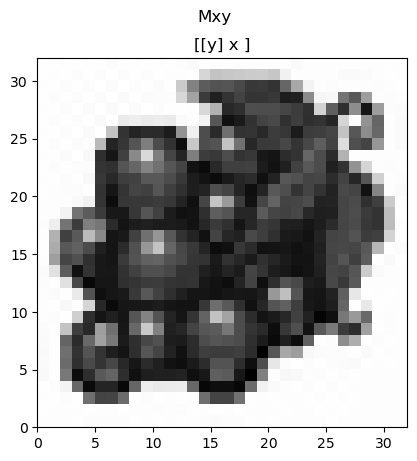

In [475]:
# insert the SENSE() linop, and take its adjoint
A = mr.linop.Sense(sens, coord=k, ishape=d.shape).H

# apply the linop A to your pulses
m = A*pulses

pl.ImagePlot(m, title = 'Mxy')

## Problem 4e: Use a bloch simulator to check the actual magnetization profile.

A better way of verifying the accuracy of the pulses is by performing a bloch simulation. Do so using the [sigpy.mri.rf.sim.abrm_ptx() function](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.sim.abrm_ptx.html#sigpy.mri.rf.sim.abrm_ptx).

Plot the Mxy and Mz profile once you're done. 

In [476]:
# simulation code is written below: 
x, y = np.meshgrid(np.linspace(fov/2, -fov/2, dim_x), np.linspace(fov/2, -fov/2, dim_y))
spatial = np.fliplr(np.concatenate((np.reshape(x, (dim_x*dim_y, 1)), np.reshape(y, (dim_x*dim_y, 1))), axis=1))
gam = 42580 # Hz/mT
a, b, m, mz = rf.abrm_ptx(pulses/33, spatial, g * gam * gts * 2 * np.pi, gts, fmap=None, sens=sens)

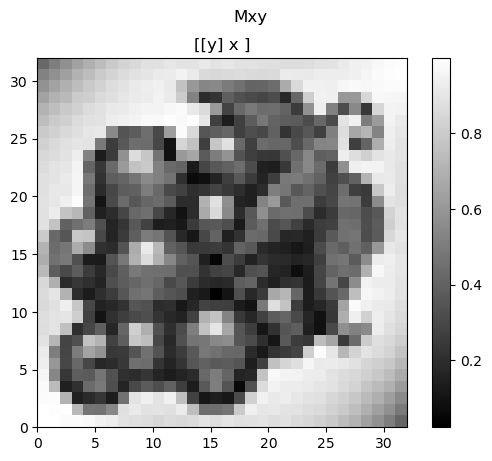

In [489]:
pl.ImagePlot(np.reshape(2*a*np.conj(b),img_shape), mode='m', title=('Mxy'), colormap="gray")


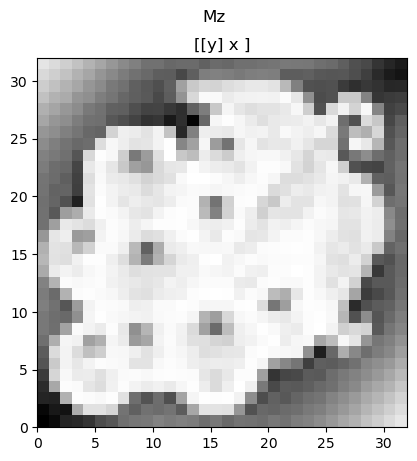

In [478]:
pl.ImagePlot(np.reshape(1-2*np.absolute(b)**2,img_shape), mode='m', title=('Mz'))